### import modules

In [1]:
# to remove depreciationWarning
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from IPython.display import HTML
css_str = '<style> \
.jp-Button path { fill: #616161;} \
text.terms { fill: #616161;} \
.jp-icon-warn0 path {fill: var(--jp-warn-color0);} \
.bp3-button-text path { fill: var(--jp-inverse-layout-color3);} \
.jp-icon-brand0 path { fill: var(--jp-brand-color0);} \
text.terms { fill: #616161;} \
</style>'
display(HTML(css_str ))

In [2]:
import numpy as np
import pandas as pd
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline
from pprint import pprint

- Import NLTK for common stop words
- This list of stopwords will be extended. The extension words are corpus specific

In [3]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# stop_words.extend(['davao','city','government','ordinance','series'])
# stop_words.extend(['davao', 'city', 'government','ordinance','barangay', 'known','otherwise','thereof','therefor','purposes','mayor','amended', 'series','enter','sign'])
# stop_words.extend(['thereof','shall','barangay','ordinance','known','otherwise','city','davao','government','memorandum','code','sign','mayor','behalf','series','purposes','comprehensive','agreement','enter','section','entered','amended'])
# stop_words.extend(['ordinance','government','series','amending','otherwise','known','davao','city','government','sign','purposes','behalf','authorizing','providing',
# 'section','granting','providing','use','sign','code','thereof','agreement','enter','use','act','ii','xi','article','memorandum','barangay','mayor'])
# stop_words.extend(['ordinance','tagum','city','thereof','section','municipal','municipality','ii','davao','sign','enter','amending','granting','authorizing','behalf','mayor','approving','authority'])

### Import Tagum dataset

In [4]:
df = pd.read_csv('ordinances/davao_ordinances.csv', header = 0)
print(df)
df.head()

            OR                                                 OT
0    000172-14  An Ordinance amending Section 42 of the 2005 R...
1    000177-14  An Ordinance placing underground all electrica...
2    000178-14  An Ordinance amending City Ordinance No. 0195-...
3    000173-14  An Ordinance regulating the use of some street...
4    000227-14  An ordinance for the creation of Trust Fund Ac...
..         ...                                                ...
414  000496-13  An Ordinance authorizing the City Mayor to ent...
415  000487-16  An Ordinance amending Section 13 Article XI of...
416  000348-07  Ordinance  Establishing the Gender-Sensitive C...
417  000349-07  ORDINANCE AMENDING DAVAO CITY ORDINANCE NO. 15...
418  000355-07  An  Ordinance  for  the  "Davao  Branding  Sys...

[419 rows x 2 columns]


,OR,OT
0,000172-14,An Ordinance amending Section 42 of the 2005 R...
1,000177-14,An Ordinance placing underground all electrica...
2,000178-14,An Ordinance amending City Ordinance No. 0195-...
3,000173-14,An Ordinance regulating the use of some street...
4,000227-14,An ordinance for the creation of Trust Fund Ac...


Add ordinance descriptions to a list

In [5]:
data = list(df.OT) 
print(data[:1]) # preview

['An Ordinance amending Section 42 of the 2005 Revenue Code of Davao City from "Time and Place of the Payment - The tax shall be due and payable in advance to the City Treasurer or his duly authorized representative before the materials are extracted and shall be based on the volume applied for in the application for quarry concession" to "Tax shall be due and payable every quarter of the Calendar Year to the City Treasurer or his duly authorized representative after the materials are extracted based on the volume applied for in the application for quarry concession"']


Use regular expression to remove words ending with ING.
(Seems to improve topics)

In [22]:
import re
newStops = []
i = 0
# add words next to ordinance to stops words list 
while i < len(data):
    try:
        newStops.append(re.search(r'(?<=Ordinance )(\w+)', data[i]).group(1))
    except AttributeError:
        None
    i +=1
stop_words.extend(newStops)
print(len(data))
print(new)

419
['amending', 'placing', 'amending', 'regulating', 'granting', 'regulating', 'granting', 'No', 'No', 'known', 'regulating', 'approving', 'allowing', 'further', 'renaming', 'to', 'No', 'No', 'No', 'No', 'No', 'renaming', 'No', 'No', 'for', 'No', 'No', 'of', 'known', 'granting', 'No', 'No', 'approving', 'No', 'of', 'institutionalizing', 'amending', 'No', 'No', 'requiring', 'prohibiting', 'authorizing', 'naming', 'amending', 'naming', 'renaming', 'amending', 'enjoining', 'specifying', 'granting', 'specifying', 'granting', 'for', 'fixing', 'penalyzing', 'directing', 'implementing', 'accepting', 'authorizing', 'granting', 'authorizing', 'adopting', 'adopting', 'Regulating', 'No', 'amending', 'to', 'granting', 'No', 'Amending', 'No', 'amending', 'Creating', 'No', 'No', 'approving', 'constituting', 'approving', 'Creating', 'Legalizing', 'prohibiting', 'approving', 'Requiring', 'regulating', 'granting', 'adopting', 'No', 'requiring', 'Creating', 'No', 'of', 'No', 'requiring', 'requiring', '

/Users/coriv/Developer/Ordinances_LDA/Ordinances_LDA/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/coriv/Developer/Ordinances_LDA/Ordinances_LDA/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/coriv/Developer/Ordinances_LDA/Ordinances_LDA/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/coriv/Developer/Ordinances_LDA/Ordinances_LDA/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative us

Tokenize and preprocess text

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

pprint(data_words[:1])

[['an',
  'ordinance',
  'amending',
  'section',
  'of',
  'the',
  'revenue',
  'code',
  'of',
  'davao',
  'city',
  'from',
  'time',
  'and',
  'place',
  'of',
  'the',
  'payment',
  'the',
  'tax',
  'shall',
  'be',
  'due',
  'and',
  'payable',
  'in',
  'advance',
  'to',
  'the',
  'city',
  'treasurer',
  'or',
  'his',
  'duly',
  'authorized',
  'representative',
  'before',
  'the',
  'materials',
  'are',
  'extracted',
  'and',
  'shall',
  'be',
  'based',
  'on',
  'the',
  'volume',
  'applied',
  'for',
  'in',
  'the',
  'application',
  'for',
  'quarry',
  'concession',
  'to',
  'tax',
  'shall',
  'be',
  'due',
  'and',
  'payable',
  'every',
  'quarter',
  'of',
  'the',
  'calendar',
  'year',
  'to',
  'the',
  'city',
  'treasurer',
  'or',
  'his',
  'duly',
  'authorized',
  'representative',
  'after',
  'the',
  'materials',
  'are',
  'extracted',
  'based',
  'on',
  'the',
  'volume',
  'applied',
  'for',
  'in',
  'the',
  'application',
  'f

In [8]:
# Remove Stop Words
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

data_words_nostops = remove_stopwords(data_words)

# Create Dictionary
id2word = corpora.Dictionary(data_words_nostops)

# Create Corpus
texts = data_words_nostops

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 2), (2, 2), (3, 2), (4, 2), (5, 1), (6, 3), (7, 1), (8, 2), (9, 1), (10, 2), (11, 2), (12, 1), (13, 2), (14, 2), (15, 1), (16, 2), (17, 1), (18, 1), (19, 2), (20, 1), (21, 2), (22, 1), (23, 1), (24, 2), (25, 1), (26, 2), (27, 2), (28, 1)]]


In [9]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('advance', 1),
  ('application', 2),
  ('applied', 2),
  ('authorized', 2),
  ('based', 2),
  ('calendar', 1),
  ('city', 3),
  ('code', 1),
  ('concession', 2),
  ('davao', 1),
  ('due', 2),
  ('duly', 2),
  ('every', 1),
  ('extracted', 2),
  ('materials', 2),
  ('ordinance', 1),
  ('payable', 2),
  ('payment', 1),
  ('place', 1),
  ('quarry', 2),
  ('quarter', 1),
  ('representative', 2),
  ('revenue', 1),
  ('section', 1),
  ('tax', 2),
  ('time', 1),
  ('treasurer', 2),
  ('volume', 2),
  ('year', 1)]]

In [10]:
# Build LDA model

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,workers=3,
                                           num_topics=15, 
                                           random_state=123,
                                           
                                           chunksize=100,
                                           passes=30,
                                          
                                           per_word_topics=True)

In [11]:
doc_lda = lda_model[corpus]

In [12]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=123,
                                           chunksize=100,
                                           passes=30,
                                           workers=3,
                                           per_word_topics=True)
        model_list.append(lda_model)
        coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

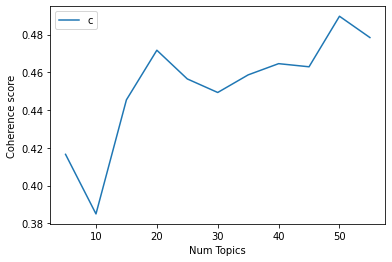

Model: ( 0 ) Num Topics = 5  has Coherence Value of 0.4165
Model: ( 1 ) Num Topics = 10  has Coherence Value of 0.3849
Model: ( 2 ) Num Topics = 15  has Coherence Value of 0.4454
Model: ( 3 ) Num Topics = 20  has Coherence Value of 0.4717
Model: ( 4 ) Num Topics = 25  has Coherence Value of 0.4565
Model: ( 5 ) Num Topics = 30  has Coherence Value of 0.4493
Model: ( 6 ) Num Topics = 35  has Coherence Value of 0.4586
Model: ( 7 ) Num Topics = 40  has Coherence Value of 0.4646
Model: ( 8 ) Num Topics = 45  has Coherence Value of 0.4629
Model: ( 9 ) Num Topics = 50  has Coherence Value of 0.4897
Model: ( 10 ) Num Topics = 55  has Coherence Value of 0.4784


In [13]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=5, limit=60, step=5)

# Show graph to find optimal number of topics
# Coherence value not going flat seems unlikely or probably wrong
limit=60; start=5; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
model_number = -1
for m, cv in zip(x, coherence_values):
    model_number += 1
    print("Model: (", model_number,") Num Topics =", m, " has Coherence Value of", round(cv, 4))

K = 15 is the optimal number of topics since when

In [23]:
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.061*"barangay" + 0.043*"city" + 0.029*"construction" + 0.029*"government" '
  '+ 0.027*"davao" + 0.022*"classrooms" + 0.019*"welfare" + 0.018*"ordinance" '
  '+ 0.018*"social" + 0.018*"dswd"'),
 (1,
  '0.077*"city" + 0.058*"davao" + 0.035*"ordinance" + 0.027*"government" + '
  '0.019*"housing" + 0.015*"donation" + 0.014*"hundred" + 0.014*"executed" + '
  '0.013*"sign" + 0.013*"behalf"'),
 (2,
  '0.032*"ordinance" + 0.022*"self" + 0.022*"tower" + 0.021*"support" + '
  '0.021*"legislative" + 0.021*"inc" + 0.020*"authority" + 0.020*"buhangin" + '
  '0.020*"meter" + 0.020*"globe"'),
 (3,
  '0.053*"health" + 0.032*"management" + 0.032*"davao" + 0.028*"city" + '
  '0.027*"ordinance" + 0.020*"development" + 0.014*"street" + 0.014*"chd" + '
  '0.012*"conservation" + 0.011*"center"'),
 (4,
  '0.062*"city" + 0.035*"davao" + 0.025*"government" + 0.023*"ordinance" + '
  '0.014*"mayor" + 0.010*"ii" + 0.010*"district" + 0.009*"act" + 0.008*"code" '
  '+ 0.008*"personnel"'),
 (5,
  '0.131*"

In [24]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,19.0,0.9798,"ordinance, film, june, festival, city, davao, series, resolution, international, pambansa","An Ordinance amending Section 42 of the 2005 Revenue Code of Davao City from ""Time and Place of the Payment - The tax shall be due and payable in advance to the City Treasurer or his duly authorized representative before the materials are extracted and shall be based on the volume applied for in the application for quarry concession"" to ""Tax shall be due and payable every quarter of the Calendar Year to the City Treasurer or his duly authorized representative after the materials are extracted based on the volume applied for in the application for quarry concession"""
1,1,4.0,0.9321,"city, davao, government, ordinance, mayor, ii, district, act, code, personnel",An Ordinance placing underground all electrical and telecommunication wires and cables within the vicinity of City Hall and the Sangguniang Panlungsod of the City of Davao
2,2,5.0,0.6066,"ordinance, city, davao, series, otherwise, code, amended, section, purposes, operation","An Ordinance amending City Ordinance No. 0195-14, Series of 2004, otherwise known as the ""Amended rerouting scheme of Davao City"" for a 90-day experimental period"
3,3,4.0,0.5366,"city, davao, government, ordinance, mayor, ii, district, act, code, personnel","An Ordinance regulating the use of some streets near the Mintal Public Market in Barangay Mintal, Tugbok District, this city"
4,4,5.0,0.5372,"ordinance, city, davao, series, otherwise, code, amended, section, purposes, operation",An ordinance for the creation of Trust Fund Account for the Office of the Building Official and prescribing procedural guidelines for the disposition and use of the Fifteen Percent (15%) generated from building permit fees and other charges under the National Building Code of the Philippines (PD 1096)
5,5,5.0,0.5515,"ordinance, city, davao, series, otherwise, code, amended, section, purposes, operation",An ordinance amending the Tourism Code of Davao City
6,6,18.0,0.9694,"city, davao, government, mayor, behalf, sign, memorandum, ordinance, agreement, enter","An Ordinance granting Legislative Authority to City Mayor Rodrigo R. Duterte to enter into and sign, for and in behalf of the City Government of Dava (CGD), the Partnership Agreement between the Philippine Commission on Women and the City Government of Davao for the implementation of the Local Gender and Development Resource Program in Davao City"
7,7,18.0,0.5962,"city, davao, government, mayor, behalf, sign, memorandum, ordinance, agreement, enter","An ordinance granting legislative authority to City Mayor Rodrigo R. duterte, to sign for and in behalf of the City Government of Davao the Memorandum of Understanding to be entered into by and between Alsons Development & Investment Corporation (ALSONS DEV) and the City Government of Davao relative to the establishment of 911 Satellite Office in Cabantian, Davao City"
8,8,5.0,0.5013,"ordinance, city, davao, series, otherwise, code, amended, section, purposes, operation",An Ordinance regulating motorcades within the territorial jurisdiction of Davao City
9,9,18.0,0.9568,"city, davao, government, mayor, behalf, sign, memorandum, ordinance, agreement, enter","An ordinance authorizing the City Mayor, Rodrigo R. Duterte, to enter into and sign, for and in behalf of the City Government of Davao, the Memorandum of Understanding (MOU) of the Friendship City Agreement between Davao City and Lucena City"


In [25]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 1000

documents_topic = pd.DataFrame()


sent_topics_sorteddf = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf.head(55)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9833,"barangay, city, construction, government, davao, classrooms, welfare, ordinance, social, dswd","AN ORDINANCE GRANTING LEGISLATIVE AUTHORITY TO THE CITY MAYOR TO SIGN, FOR AND IN BEHALF OF THE CITY GOVERNMENT OF DAVAO, THE SPECIFIC IMPLEMENTATION ARRANGEMENTS FOR THE CONSTRUCTION OF CLASSROOMS FOR LUMADS, TO BE ENTERED INTO BY AND AMONG THE CITY GOVERNMENT OF DAVAO, THE DEPARTMENT OF SOCIAL WELFARE AND DEVELOPMENT (DSWD), INDIGENOUS PEOPLE MANDATORY REPRESENTATIVE (IPMR) AND THE BARANGAY LOCAL GOVERNEMNT OF BARANGAY DATU SALUMAY RELATIVE TO THE CONSTRUCTION OF TWO (2) CLASSROOMS AT SITIO MISOHUMAY, BARANGAY DATU SALUMAY, MARILOG DISTRICT IN THE AMOUNT OF ONE MILLION FIVE HUNDRED SEVENTY THOUSAND PESOS (P1,570.000.00)"
1,1.0,0.9836,"city, davao, ordinance, government, housing, donation, hundred, executed, sign, behalf","An Ordinance granting authority to the City Mayor to accept and sign, for and in behalf of the City Government of Davao, the Deed of Donation to be executed by Alsons Development and Investment Corporation in favor of the City Government of Davao relative to the building for Police Sub-Station and 911 Satellite Station on Lot 1415-A-1-A-4 located in Barangay Cabantian, Buhangin District, Davao City; building for the Fire Station on Lot 1415-A-1-6 located in Barangay Cabantian, Buhangin District, Davao City; and one (1) unit Toyota Hi-Ace Commuter Ambulance for the use of the 911 Satellite Station"
2,2.0,0.9672,"ordinance, self, tower, support, legislative, inc, authority, buhangin, meter, globe","AN ORDINANCE GRANTING LEGISLATIVE AUTHORITY TO EFB GEOSTRUCKT, INC. FOR THE CONSTUCTION, INSTALLATION AND OPERATION OF GLOBE TELECOM`S 40.0 METER 3-LEGGED SELF SUPPORT CELL SITE TOWER AT TIGATTO ROAD, BREAD VILLAGE, BARANGAY BUHANGIN PROPER, BUHANGIN DISTRICT,THIS CITY"
3,3.0,0.9694,"health, management, davao, city, ordinance, development, street, chd, conservation, center","Ordinance prohibiting the establishment of funeral parlors/memorial homes within the radius of two hundred (200) meters from residential areas, commercial buildings, hotels, motels, sports complex, parks and playgrounds, tourist centers, institutional buildings including cockpits within the City of Davao"
4,4.0,0.9880,"city, davao, government, ordinance, mayor, ii, district, act, code, personnel","An Ordinance granting authority to the City Mayor to release the Productivity Enhancement Incentive (PEI) based on Resolution No. 012-13, Series of 2013 of the Local Finance Committee (LFC), City Government of Davao entitled ""Recommending approval the implementing guidelines on the grant of incentive for plantilla personnel consultants, job order/contract of service, including grant-in-aid, day care workers, barangay health workers, barangay nutrition scholars, and auxilliary personnel of the City Government of Davao, in recognition of their valuable support in the performance of actual duties and responsibilities towards the attainment and successful accomplishment of the city`s vision, mission and goal, chargeable against any savings of 2013 appropriations,"" in accordance with the Deparrtment of Budget and Management (DBM) guidelines, subject to Commission on Audit (COA) auditing rules and regulations"
5,5.0,0.9728,"ordinance, city, davao, series, otherwise, code, amended, section, purposes, operation","Ordinance further Amending Ordinance No. 0253-06, an Ordinance amending the provision of Section 69, paragraph (d) of City Ordinance No. 158-05, Series of 2005, otherwise known as “The 2005 Revenue Code of the City of Davao”, specifically Section 4 thereof, by deleting the phrase: “to be imposed on essential and non-essential commodities,” which shall now read as follows: “The provision of this Ordinance shall be applicable only to retailers with gross sales/receipts in excess of P400,000.00"""
6,6.0,0.9736,"city, davao, government, ordinance, mayor, sign, behalf, enter, development

In [31]:
# df_sorted_by_topic = df_dominant_topic.sort_values(by=['Dominant_Topic'])
# documents with topic 7.0 as dominant topic
df_sorted_by_topic = df_dominant_topic.loc[df_dominant_topic['Dominant_Topic'] == 0.0]

df_sorted_by_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
89,89,0.0,0.9604,"barangay, city, construction, government, davao, classrooms, welfare, ordinance, social, dswd","An Ordinance for the one-way vehicular traffic of Toril Public Market Main Road, Road 1, Road 2, Road 3, and Lao Street (corner Main Road to Agton Street), Toril Poblacion, this City"
219,219,0.0,0.9814,"barangay, city, construction, government, davao, classrooms, welfare, ordinance, social, dswd","AN ORDINANCE GRANTING LEGISLATIVE AUTHORITY TO THE CITY MAYOR TO SIGN, FOR AND IN BEHALF OF THE CITY GOVERNMENT OF DAVAO, THE SPECIFIC IMPLEMENTATION ARRANGEMENTS FOR THE CONSTRUCTION OF CLASSROOMS FOR LUMADS, TO BE ENTERED INTO BY AND AMONG THE CITY GOVERNMENT OF DAVAO, DEPARTMENT OF SOCIAL WELFARE AND DEVELOPMENT (DSWD), INDIGENOUS PEOPLE MANDATORY REPRESENTATIVE (IPMR) AND THE BARANGAY LOCAL GOVERNMENT OF BARANGAY MARILOG PROPER RELATIVE TO THE CONSTRUCTION OF FOUR (4) CLASSROOMS AT SITIO LAPINIG AND GUILON, BARANGAY MARILOG PROPER, MARILOG DISTRICT, THIS CITY"
220,220,0.0,0.8567,"barangay, city, construction, government, davao, classrooms, welfare, ordinance, social, dswd","AN ORDINANCE GRANTING LEGISLATIVE AUTHORITY TO THE CITY MAYOR TO SIGN, FOR AND IN BEHALF OF THE CITY GOVERNMENT OF DAVAO, THE SPECIFIC IMPLEMENTATION ARRANGEMENTS FOR THE CONSTRUCTION OF CLASSROOMS FOR LUMADS, TO BE ENTERED INTO BY AND AMONG THE CITY GOVERNMENT OF DAVAO, DEPARTMENT OF SOCIAL WELFARE AND DEVELOPMENT (DSWD), INDIGENOUS PEOPLE MANDATORY REPRESENTATIVE (IPMR) AND THE BARANGAY LOCAL GOVERNMENT OF BARANGAY TAMBOBONG RELATIVE TO THE CONSTRUCTION OF TWO (2) CLASSROOMS AT SITIO LUYAN, BARANGAY TAMBOBONG, BAGUIO DISTRICT, THIS CITY"
386,386,0.0,0.9441,"barangay, city, construction, government, davao, classrooms, welfare, ordinance, social, dswd",An ordinance granting retirement and other benefits to all qualified Barangay Health Workers (BHWs) and Barangay Nutrition Scholars (BNS) in Davao City and providing funds thereof
399,399,0.0,0.9833,"barangay, city, construction, government, davao, classrooms, welfare, ordinance, social, dswd","AN ORDINANCE GRANTING LEGISLATIVE AUTHORITY TO THE CITY MAYOR TO SIGN, FOR AND IN BEHALF OF THE CITY GOVERNMENT OF DAVAO, THE SPECIFIC IMPLEMENTATION ARRANGEMENTS FOR THE CONSTRUCTION OF CLASSROOMS FOR LUMADS, TO BE ENTERED INTO BY AND AMONG THE CITY GOVERNMENT OF DAVAO, THE DEPARTMENT OF SOCIAL WELFARE AND DEVELOPMENT (DSWD), INDIGENOUS PEOPLE MANDATORY REPRESENTATIVE (IPMR) AND THE BARANGAY LOCAL GOVERNEMNT OF BARANGAY DATU SALUMAY RELATIVE TO THE CONSTRUCTION OF TWO (2) CLASSROOMS AT SITIO MISOHUMAY, BARANGAY DATU SALUMAY, MARILOG DISTRICT IN THE AMOUNT OF ONE MILLION FIVE HUNDRED SEVENTY THOUSAND PESOS (P1,570.000.00)"
400,400,0.0,0.8633,"barangay, city, construction, government, davao, classrooms, welfare, ordinance, social, dswd","AN ORDINANCE GRANTING LEGISLATIVE AUTHORITY TO THE CITY MAYOR TO ENTER INTO AND SIGN, FOR AND IN BEHALF OF THE CITY GOVERNMENT OF DAVAO, THE SPECIFIC IMPLEMENTATION ARRANGEMENTS FOR THE CONSTRUCTION OF CLASSROOMS FOR LUMADS, TO BE ENTERED INTO BY AND AMONG THE CITY GOVERNMENT OF DAVAO, THE DEPARTMENT OF SOCIAL WELFARE AND DEVELOPMENT (DSWD), INDIGENOUS PEOPLE MANDATORY REPRESENTATIVE (IPMR) AND THE BARANGAY LOCAL GOVERNMENT OF BARANGAY GUMITAN RELATIVE TO THE CONSTRUCTION OF TWO (2) CLASSROOMS AT SITIO KIBANGBANG, BARANGAY GUMITAN, MARILOG DISTRICT,IN THE AMOUNT OF ONE MILLION FIVE HUNDRED SEVENTY THOUSAND PESOS (P1,570,000.00)"


In [27]:
vis = pyLDAvis.gensim_models.prepare(optimal_model, corpus, id2word)
pyLDAvis.display(vis)



/Users/coriv/Developer/Ordinances_LDA/Ordinances_LDA/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [28]:
# # 1. Wordcloud of Top N words in each topic
# from matplotlib import pyplot as plt
# from wordcloud import WordCloud, STOPWORDS
# import matplotlib.colors as mcolors

# cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

# cloud = WordCloud(stopwords=stop_words,
#                   background_color='white',
#                   width=2500,
#                   height=1800,
#                   max_words=15,
#                   colormap='tab20',
#                   color_func=lambda *args, **kwargs: cols[i],
#                   prefer_horizontal=1.0)

# topics = optimal_model.show_topics(num_topics=15,formatted=False)

# fig, axes = plt.subplots(3, 5, figsize=(12,8), sharex=True, sharey=True)

# for i, ax in enumerate(axes.flatten()):
#     fig.add_subplot(ax)
#     topic_words = dict(topics[i][1])
#     cloud.generate_from_frequencies(topic_words, max_font_size=300)
#     plt.gca().imshow(cloud)
#     plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
#     plt.gca().axis('off')


# plt.subplots_adjust(wspace=0, hspace=0)
# plt.axis('off')
# plt.margins(x=0, y=0)
# plt.tight_layout()
# plt.show()

In [29]:
# import seaborn as sns
# import matplotlib.colors as mcolors
# cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

# fig, axes = plt.subplots(3,5,figsize=(12,8), dpi=160, sharex=True, sharey=True)
# # These are the "Tableau 20" colors as RGB.    
# tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
#              (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
#              (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
#              (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
#              (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# # Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
# for i in range(len(tableau20)):    
#     r, g, b = tableau20[i]    
#     tableau20[i] = (r / 255., g / 255., b / 255.)
    
# for i, ax in enumerate(axes.flatten()):    
#     df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
#     doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
#     ax.hist(doc_lens, bins = 700, color=tableau20[i])
#     ax.tick_params(axis='y', labelcolor=tableau20[i], color=tableau20[i])
#     sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
#     ax.set(xlim=(0, 700), xlabel='Document Word Count')
#     ax.set_ylabel('Number of Documents', color=tableau20[i])
#     ax.set_title('Topic: '+str(i), fontdict=dict(size=5, color=tableau20[i]))

# fig.tight_layout()
# fig.subplots_adjust(top=0.90)
# plt.xticks(np.linspace(0,700,9))
# fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
# plt.show()

In [30]:

# # Sentence Coloring of N Sentences
# from matplotlib.patches import Rectangle

# def sentences_chart(lda_model=optimal_model, corpus=corpus, start = 0, end = 15):
#     corp = corpus[start:end]
#     mycolors = tableau20

#     fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
#     axes[0].axis('off')
#     for i, ax in enumerate(axes):
#         if i > 0:
#             corp_cur = corp[i-1] 
#             topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
#             word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
#             ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
#                     fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

#             # Draw Rectange
#             topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
#             ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
#                                    color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

#             word_pos = 0.06
#             for j, (word, topics) in enumerate(word_dominanttopic):
#                 if j < 14:
#                     ax.text(word_pos, 0.5, word,
#                             horizontalalignment='left',
#                             verticalalignment='center',
#                             fontsize=16, color=mycolors[topics],
#                             transform=ax.transAxes, fontweight=700)
#                     word_pos += .009 * len(word)  # to move the word for the next iter
#                     ax.axis('off')
#             ax.text(word_pos, 0.5, '. . .',
#                     horizontalalignment='left',
#                     verticalalignment='center',
#                     fontsize=16, color='black',
#                     transform=ax.transAxes)       

#     plt.subplots_adjust(wspace=0, hspace=0)
#     plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
#     plt.tight_layout()
#     plt.show()

# sentences_chart()